# Reproduce Paper Results

The goal of this notebook is to provide a pathway to reproduce the results presented in the paper *Langevin Bi-fidelity Importance Sampling for Rare Event Estimation*. 

If you have not done so, please download the pre-generated Langevin chain. Our experiments have to use them to reproduce the results. 

This notebook does not inlcude the results of steady-state heat equation example.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def weight(x, Zc, ell, h_LF): # evaluate the unnormalized weight for the given xi
    wt = Zc * (ell * torch.tanh(h_LF(x))).exp()
    return wt

def estimation(q_lst, h_HF, ExH, new_weight, sample):
    MC_N_lst = (10**np.linspace(1, 4, 10)).astype('int')
    MC = []
    IS = []
    num_trial = 1000
    for j in range(num_trial):
        MC_est_lst = []
        IS_est_lst = []
        for MC_N in MC_N_lst:
            xi_p = sample(MC_N) # sample MC xi_p
            ind = np.random.choice(len(q_lst), MC_N)
            xi_q = q_lst[ind] # sample xi_q
            wt_q = new_weight(xi_q) / MC_N
            MC_est_lst.append(np.mean((h_HF(xi_p) < 0).detach().numpy()))
            IS_est_lst.append(wt_q[h_HF(xi_q) < 0].sum().item())
        MC.append(MC_est_lst)
        IS.append(IS_est_lst)

    MC      = np.array(MC)
    IS      = np.array(IS)
    MC_mean = np.nanmean(MC, axis=0)
    MC_std  = np.nanstd(MC, axis=0)
    IS_mean = np.nanmean(IS, axis=0)
    IS_std  = np.nanstd(IS, axis=0)
    MC_err  = ((MC - ExH)**2)
    IS_err  = ((IS - ExH)**2)
    MC_rmse = np.sqrt(np.nanmean(MC_err, axis=0))
    IS_rmse = np.sqrt(np.nanmean(IS_err, axis=0))

    return MC_N_lst, MC_mean, MC_std, MC_rmse, IS_mean, IS_std, IS_rmse

def plot(MC_mean, MC_std, MC_rmse, IS_mean, IS_std, IS_rmse, MC_N_lst, ell, ExH, ExL, title):

    scale = 1.96
    # Plot and save the first subplot separately
    fig1, ax1 = plt.subplots(figsize=(6, 4))  # Adjust the figure size as needed
    ax1.fill_between(MC_N_lst, MC_mean-scale*MC_std, MC_mean+scale*MC_std, color='tab:purple', alpha=0.4, hatch='/', label='MC')
    ax1.fill_between(MC_N_lst, IS_mean-scale*IS_std, IS_mean+scale*IS_std, color='tab:orange', alpha=0.4, hatch='\\', label='L-BF-IS')
    ax1.axhline(ExH, color='k', label=r'$P_f$', lw=1.0)
    ax1.axhline(ExL, color='tab:blue', label=r'$P^{LF}_f$', lw=1.0, ls='--')
    ax1.set_xscale('log')
    ax1.set_xlabel(r'HF Sample Size $N$', fontsize=14)
    ax1.set_ylabel('Estimator Value', fontsize=14)
    ax1.legend()
    ax1.set_title(f'$\ell={ell:.2f}$')
    fig1.tight_layout()

    # Plot and save the second subplot separately
    fig2, ax2 = plt.subplots(figsize=(6, 4))  # Adjust the figure size as needed
    ax2.plot(MC_N_lst, MC_rmse, color='tab:purple', alpha=1.0, label='MC', lw=4.0)
    ax2.plot(MC_N_lst, IS_rmse, color='tab:orange', alpha=1.0, label='L-BF-IS', lw=4.0, ls='--')
    ax2.axhline(abs(ExH-ExL), color='tab:blue', label=r'LF Bias', lw=2.0, ls='-.')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel(r'HF Sample Size $N$', fontsize=14)
    ax2.set_ylabel('RMSE', fontsize=14)
    ax2.legend()
    ax2.set_title(f'$\ell={ell:.2f}$')
    fig2.tight_layout()
    return fig1, fig2

<>:53: SyntaxWarning: invalid escape sequence '\e'
<>:68: SyntaxWarning: invalid escape sequence '\e'
<>:53: SyntaxWarning: invalid escape sequence '\e'
<>:68: SyntaxWarning: invalid escape sequence '\e'
/var/folders/2h/qpgmp2hn60v7bxdrwgqzjb9r0000gn/T/ipykernel_2077/857287778.py:53: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_title(f'$\ell={ell:.2f}$')
/var/folders/2h/qpgmp2hn60v7bxdrwgqzjb9r0000gn/T/ipykernel_2077/857287778.py:68: SyntaxWarning: invalid escape sequence '\e'
  ax2.set_title(f'$\ell={ell:.2f}$')


## Example 3.2.1 Borehole Function

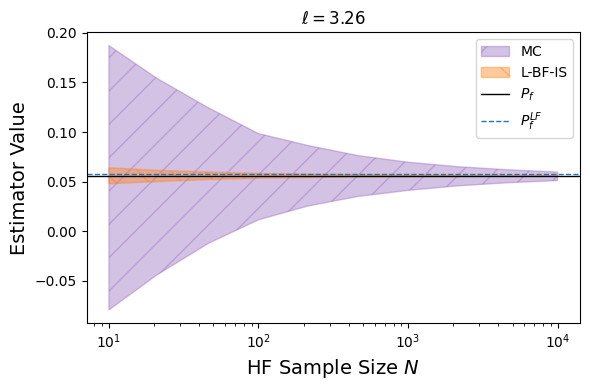

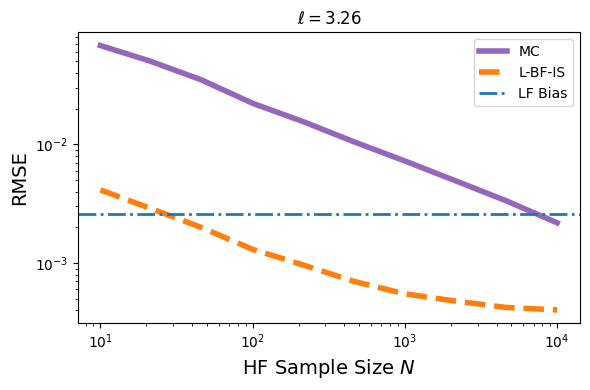

In [2]:
from BidataGen import bh_HF as HF
from BidataGen import bh_LF as LF
from BidataGen import sample_p_bh as sample

# define LF and HF functions 
def h_LF(x):
    ind1 = (x[:,:2] < -10).any(axis=1) + (x[:,:2] > 10).any(axis=1)
    ind2 = (x[:,2:] < -1).any(axis=1) + (x[:,2:] > 1).any(axis=1)
    ans = 1000 - LF(x)
    ans[ind1] = torch.norm(x[ind1], dim=1)**2
    ans[ind2] = 100 * torch.norm(x[ind2], dim=1)**2
    return ans
def h_HF(x):
    ind1 = (x[:,:2] < -10).any(axis=1) + (x[:,:2] > 10).any(axis=1)
    ind2 = (x[:,2:] < -1).any(axis=1) + (x[:,2:] > 1).any(axis=1)
    ans = 800 - HF(x)
    ans[ind1] = torch.norm(x[ind1], dim=1)**2
    ans[ind2] = 100 * torch.norm(x[ind2], dim=1)**2
    return ans

# load parameters
ell = 3.26

M = int(1e6)
samps_M = sample(M)
Zc = 1.5312
ExH = np.mean((h_HF(samps_M) < 0).detach().numpy())
ExL = np.mean((h_LF(samps_M) < 0).detach().numpy())

# load pre-generated Langevin chains
q_lst = torch.load(f'../data/borehole/q-ell{ell:.2f}.pt', weights_only=False)
new_weight = lambda x: weight(x, Zc, ell, h_LF)
MC_N_lst, MC_mean, MC_std, MC_rmse, \
    IS_mean, IS_std, IS_rmse = estimation(q_lst, h_HF, ExH, new_weight, sample)
fig1, fig2 = plot(MC_mean, MC_std, MC_rmse, IS_mean, 
           IS_std, IS_rmse, MC_N_lst, ell, ExH, ExL, title='Borehole')
plt.show()

## Example 3.2.2 1000 Dimensional Problem

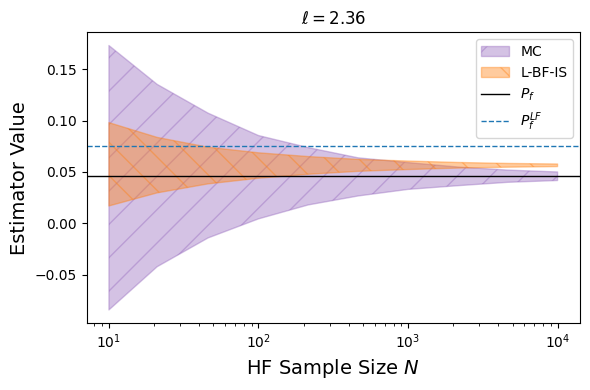

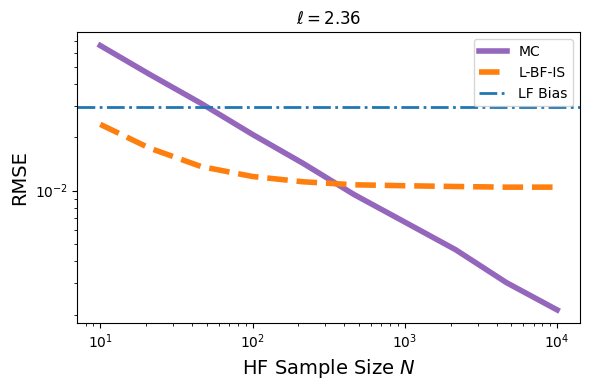

In [3]:
from BidataGen import sample_p
from BidataGen import otds_HF as HF
from BidataGen import otds_LF as LF

# define LF and HF functions 
num_variable = 1000
sample = lambda n: sample_p(n, num_variable)
def h_LF(x):
    ind = (x < -1).any(axis=1) + (x > 1).any(axis=1)
    ans = 8 - LF(x)
    ans[ind] = 100 * torch.norm(x[ind], dim=1)**2
    return ans
def h_HF(x):
    ind = (x < -1).any(axis=1) + (x > 1).any(axis=1)
    ans = 20 - HF(x)
    ans[ind] = 100 * torch.norm(x[ind], dim=1)**2
    return ans

# load parameters
ell = 2.36

M = int(1e6)
samps_M = sample(M)
h_samps_M = h_LF(samps_M)
def Zl(ell):
    return (-ell * torch.tanh(h_samps_M)).exp().sum() / M
Zc = Zl(ell)
ExH = np.mean((h_HF(samps_M) < 0).detach().numpy())
ExL = np.mean((h_samps_M < 0).detach().numpy())

# load pre-generated Langevin chains
q_lst = torch.load(f'../data/onek/q-ell{ell:.2f}.pt', weights_only=False)
new_weight = lambda x: weight(x, Zc, ell, h_LF)
MC_N_lst, MC_mean, MC_std, MC_rmse, \
    IS_mean, IS_std, IS_rmse = estimation(q_lst, h_HF, ExH, new_weight, sample)
fig = plot(MC_mean, MC_std, MC_rmse, IS_mean, IS_std, 
           IS_rmse, MC_N_lst, ell, ExH, ExL, title='1000D Function')
plt.show()

## Example 3.3.1 Composite Beam

/Users/nokic/Downloads/L-BF-IS-local/src/BidataGen.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  file = torch.load('../data/comp_beam/coefficients.pt')
/Users/nokic/

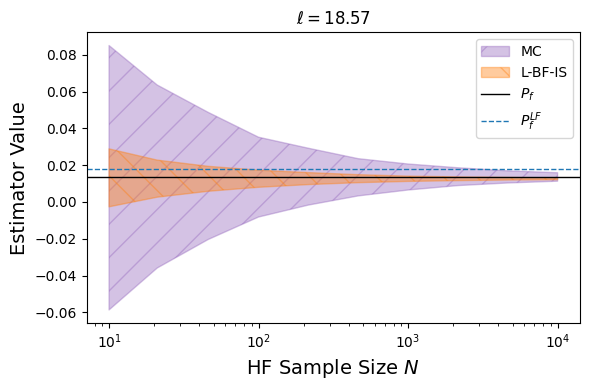

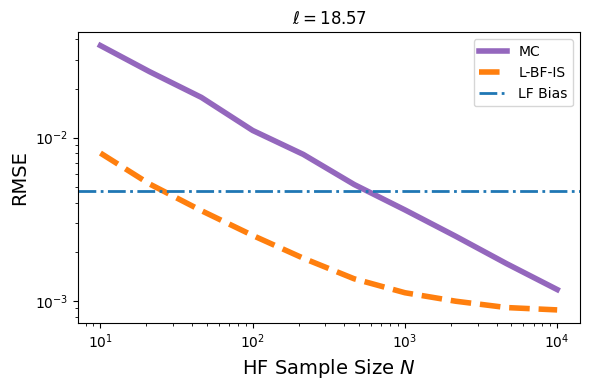

In [4]:
from BidataGen import sample_p
from BidataGen import beam_LF as LF
from BidataGen import beam_HF as HF

# define LF and HF functions 
num_variable = 4
sample = lambda n: sample_p(n, num_variable)
def h_LF(x):
    ind = (x < -1).any(axis=1) + (x > 1).any(axis=1)
    ans = 3.18 + LF(x)
    ans[ind] = 100 * torch.norm(x[ind], dim=1)**2
    return ans
def h_HF(x):
    ind = (x < -1).any(axis=1) + (x > 1).any(axis=1)
    ans = 4.04 + HF(x)
    ans[ind] = 100 * torch.norm(x[ind], dim=1)**2
    return ans

# load parameters
ell = 18.57

M = int(1e6)
samps_M = sample(M)
h_samps_M = h_LF(samps_M)
def Zl(ell):
    return (-ell * torch.tanh(h_samps_M)).exp().sum() / M
Zc = Zl(ell)
ExH = np.mean((h_HF(samps_M) < 0).detach().numpy())
ExL = np.mean((h_samps_M < 0).detach().numpy())

# load pre-generated Langevin chains
q_lst = torch.load(f'../data/comp_beam/q-ell{ell:.2f}.pt', weights_only=False)
new_weight = lambda x: weight(x, Zc, ell, h_LF)
MC_N_lst, MC_mean, MC_std, MC_rmse, \
    IS_mean, IS_std, IS_rmse = estimation(q_lst, h_HF, ExH, new_weight, sample)
fig = plot(MC_mean, MC_std, MC_rmse, IS_mean, IS_std, 
           IS_rmse, MC_N_lst, ell, ExH, ExL, title='Composite Beam')
plt.show()

## Example 3.3.2 Steady-state Heat Equation 

The implementation of this example is relatively more complicated than other examples. To reproduce the results, we follow these steps:

1. Train a Physic-informed Neural Operator (PINO) on the steady-state problem (Darcy's flow) following this [github](https://github.com/neuraloperator/physics_informed). The training process requires CUDA-supported GPUs;

2. Write the LF and HF functions with the LF function using the pre-trained PINO and HF function using finite difference. The finite difference code is provided below;

3. Given the values of $\ell = 1786$ and $M=1\times 10^6$, we should be able to generate the L-BF-IS results from the given $q$ list from *../data/darcy/q-ell1786.pt*.

In [5]:
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def solve_2d_darcy_numpy(K):
    """
    Solves the 2D Darcy flow problem ∇⋅(K(x)∇u) = 1 on a uniform grid using finite differences.
    
    Parameters:
    - K : 2D numpy.ndarray
        Spatially varying coefficient K(x, y) on a discrete grid.
        
    Returns:
    - u : 2D numpy.ndarray
        Approximated solution u(x, y) on the grid.
    """
    N, M = K.shape  # Grid size
    dx, dy = 1.0/M, 1.0/N  # Grid spacing
    A = lil_matrix((N*M, N*M))
    b = -np.ones(N*M)
    
    for i in range(N):
        for j in range(M):
            index = i*M + j
            if i == 0 or i == N-1 or j == 0 or j == M-1:
                # Apply boundary conditions (u = 0 on boundaries)
                A[index, index] = 1
                b[index] = 0
            else:
                # Central differences for interior points
                K_e = (K[i, j] + K[i+1, j]) / 2
                K_w = (K[i, j] + K[i-1, j]) / 2
                K_n = (K[i, j] + K[i, j+1]) / 2
                K_s = (K[i, j] + K[i, j-1]) / 2
                
                A[index, index] = -(K_e + K_w) / dx**2 - (K_n + K_s) / dy**2
                A[index, index+1] = K_n / dy**2
                A[index, index-1] = K_s / dy**2
                A[index, index+M] = K_e / dx**2
                A[index, index-M] = K_w / dx**2
    
    # Solve the linear system
    u_vector = spsolve(A.tocsr(), b)
    
    # Reshape the solution vector into the 2D grid
    u = u_vector.reshape(N, M)
    
    return u